In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import wandb
from torch.amp import GradScaler, autocast

wandb.login(key="d6f8c99f1fd73267470842bbf00f03ae845f7308")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24m014 (da24m014-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
class CustomCNN(nn.Module):
    def __init__(self, in_channels=3, conv_configs=[(32, 3), (64, 3), (128, 3), (128, 3), (256, 3)],
                 activation_fn=nn.ReLU, dense_neurons=512, dropout_rate=0.5, num_classes=10, input_size=224):
        super(CustomCNN, self).__init__()
        self.conv_blocks = nn.ModuleList()
        current_in_channels = in_channels

        for out_channels, kernel_size in conv_configs:
            block = nn.Sequential(
                nn.Conv2d(current_in_channels, out_channels, kernel_size=kernel_size, padding=1),
                nn.BatchNorm2d(out_channels),
                activation_fn(),
                nn.Dropout2d(dropout_rate),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
            self.conv_blocks.append(block)
            current_in_channels = out_channels

        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, input_size, input_size)
            x = dummy_input
            for block in self.conv_blocks:
                x = block(x)
            self.flattened_size = x.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(self.flattened_size, dense_neurons),
            activation_fn(),
            nn.Dropout(dropout_rate),
            nn.Linear(dense_neurons, num_classes)
        )

    def forward(self, x):
        for block in self.conv_blocks:
            x = block(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [3]:
# def estimate_parameters_and_computations(num_layers, in_channels, m, k, input_size, dense_neurons, num_classes=10):
#     total_params = 0
#     total_ops = 0
#     current_size = input_size
#     current_channels = in_channels

#     for _ in range(num_layers):
#         conv_params = m * (current_channels * k * k + 1)
#         total_params += conv_params
#         current_size = current_size // 2
#         output_elements = m * current_size * current_size
#         conv_ops = output_elements * (current_channels * k * k)
#         total_ops += conv_ops
#         current_channels = m

#     fc_input = m * current_size * current_size
#     total_params += fc_input * dense_neurons + dense_neurons
#     total_params += dense_neurons * num_classes + num_classes
#     total_ops += fc_input * dense_neurons + dense_neurons * num_classes

#     return total_params, total_ops


In [4]:
def get_dataloaders(data_dir, batch_size=64, img_size=224, val_split=0.2, augment=True):
    if augment:
        train_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])

    test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])

    full_train = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
    train_size = int((1 - val_split) * len(full_train))
    val_size = len(full_train) - train_size
    train_ds, val_ds = random_split(full_train, [train_size, val_size])
    test_ds = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=test_transform)

    return {
        "train": DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True),
        "val": DataLoader(val_ds, batch_size=batch_size, num_workers=2, pin_memory=True),
        "test": DataLoader(test_ds, batch_size=batch_size, num_workers=2, pin_memory=True)
    }

In [5]:
def train_one_epoch(model, dataloader, loss_fn, optimizer, device, scaler, clip_grad=1.0):
    model.train()
    total_loss, correct = 0, 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        with autocast(device_type="cuda"):
            preds = model(x)
            loss = loss_fn(preds, y)

        scaler.scale(loss).backward()
        if clip_grad:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * x.size(0)
        correct += (preds.argmax(1) == y).sum().item()

    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            with autocast(device_type="cuda"):
                preds = model(x)
                loss = loss_fn(preds, y)
            total_loss += loss.item() * x.size(0)
            correct += (preds.argmax(1) == y).sum().item()
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

In [6]:
def train_with_wandb(config=None):
    with wandb.init(config=config):
        config = wandb.config
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        dataloaders = get_dataloaders(
            data_dir="/kaggle/input/nature/nature_12K/inaturalist_12K",
            batch_size=config.batch_size,
            augment=config.augment
        )

        model = CustomCNN(
            conv_configs=[(f, 3) for f in config.filters],
            activation_fn=getattr(nn, config.activation),
            dense_neurons=config.dense_units,
            dropout_rate=config.dropout,
            num_classes=10,
            input_size=224
        ).to(device)

        wandb.watch(model, log="all")

        optimizer = optim.Adam(model.parameters(), lr=config.lr)
        loss_fn = nn.CrossEntropyLoss()
        scaler = GradScaler()

        best_val_acc = 0.0
        best_config = None

        for epoch in range(config.epochs):
            train_loss, train_acc = train_one_epoch(
                model, dataloaders["train"], loss_fn, optimizer, device, scaler, clip_grad=1.0
            )
            val_loss, val_acc = evaluate(model, dataloaders["val"], loss_fn, device)

            wandb.log({
                "epoch": epoch,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
            })

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), "best_model.pth")
                best_config = dict(config)

        if best_config is not None:
            with open("best_config.json", "w") as f:
                json.dump(best_config, f)
            wandb.save("best_model.pth")
            wandb.save("best_config.json")

In [7]:
sweep_config = {
    "method": "bayes",
    "metric": {"name": "val_acc", "goal": "maximize"},
    "parameters": {
        "epochs": {"value": 10},
        "batch_size": {"values": [32, 64]},
        "lr": {"values": [0.001, 0.0005]},
        "filters": {"values": [[32, 64, 128, 128, 256], [64, 64, 128, 128, 256]]},
        "activation": {"values": ["ReLU", "GELU", "SiLU"]},
        "dense_units": {"values": [256, 512, 1024]},
        "dropout": {"values": [0.2, 0.3]},
        "augment": {"values": [True, False]}
    }
}

In [8]:
if __name__ == "__main__":
    sweep_id = wandb.sweep(sweep_config, project="DLA2")
    wandb.agent(sweep_id, function=train_with_wandb,count=15)

Create sweep with ID: kuyjwinl
Sweep URL: https://wandb.ai/da24m014-iit-madras/DLA2/sweeps/kuyjwinl


wandb: Agent Starting Run: tn8zrc28 with config:
wandb: 	activation: GELU
wandb: 	augment: True
wandb: 	batch_size: 32
wandb: 	dense_units: 512
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 128, 128, 256]
wandb: 	lr: 0.0005
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Agent Starting Run: slvv4so1 with config:
wandb: 	activation: SiLU
wandb: 	augment: True
wandb: 	batch_size: 64
wandb: 	dense_units: 512
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filters: [32, 64, 128, 128, 256]
wandb: 	lr: 0.001


wandb: Agent Starting Run: 3sljw44e with config:
wandb: 	activation: SiLU
wandb: 	augment: False
wandb: 	batch_size: 64
wandb: 	dense_units: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filters: [32, 64, 128, 128, 256]
wandb: 	lr: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8b04f8ws with config:
wandb: 	activation: GELU
wandb: 	augment: True
wandb: 	batch_size: 32
wandb: 	dense_units: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 128, 128, 256]
wandb: 	lr: 0.0005


wandb: Agent Starting Run: 9ror3a5h with config:
wandb: 	activation: ReLU
wandb: 	augment: False
wandb: 	batch_size: 64
wandb: 	dense_units: 512
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 128, 128, 256]
wandb: 	lr: 0.0005


wandb: Agent Starting Run: 67p6raoy with config:
wandb: 	activation: SiLU
wandb: 	augment: True
wandb: 	batch_size: 32
wandb: 	dense_units: 512
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 128, 128, 256]
wandb: 	lr: 0.001


wandb: Agent Starting Run: 9vebxax1 with config:
wandb: 	activation: GELU
wandb: 	augment: True
wandb: 	batch_size: 32
wandb: 	dense_units: 1024
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 128, 128, 256]
wandb: 	lr: 0.001


wandb: Agent Starting Run: s715qx7h with config:
wandb: 	activation: GELU
wandb: 	augment: True
wandb: 	batch_size: 32
wandb: 	dense_units: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 128, 128, 256]
wandb: 	lr: 0.0005


wandb: Agent Starting Run: 92do3xcm with config:
wandb: 	activation: GELU
wandb: 	augment: False
wandb: 	batch_size: 64
wandb: 	dense_units: 1024
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 128, 128, 256]
wandb: 	lr: 0.0005


wandb: Agent Starting Run: mj5iptwj with config:
wandb: 	activation: GELU
wandb: 	augment: True
wandb: 	batch_size: 64
wandb: 	dense_units: 1024
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 128, 128, 256]
wandb: 	lr: 0.0005


wandb: Agent Starting Run: j9ohibzi with config:
wandb: 	activation: ReLU
wandb: 	augment: True
wandb: 	batch_size: 64
wandb: 	dense_units: 1024
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 128, 128, 256]
wandb: 	lr: 0.0005


wandb: Agent Starting Run: zynr2wdh with config:
wandb: 	activation: ReLU
wandb: 	augment: False
wandb: 	batch_size: 64
wandb: 	dense_units: 512
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 128, 128, 256]
wandb: 	lr: 0.0005


wandb: Agent Starting Run: bdmxytr9 with config:
wandb: 	activation: ReLU
wandb: 	augment: True
wandb: 	batch_size: 64
wandb: 	dense_units: 512
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 128, 128, 256]
wandb: 	lr: 0.0005


wandb: Agent Starting Run: a86t466u with config:
wandb: 	activation: GELU
wandb: 	augment: False
wandb: 	batch_size: 64
wandb: 	dense_units: 1024
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 128, 128, 256]
wandb: 	lr: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vr8fbxqz with config:
wandb: 	activation: GELU
wandb: 	augment: False
wandb: 	batch_size: 64
wandb: 	dense_units: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 128, 128, 256]
wandb: 	lr: 0.0005


/tmp/ipykernel_31/3102598173.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_dir, "best_model.pth"), map_location=de

✅ Test Accuracy: 0.3615


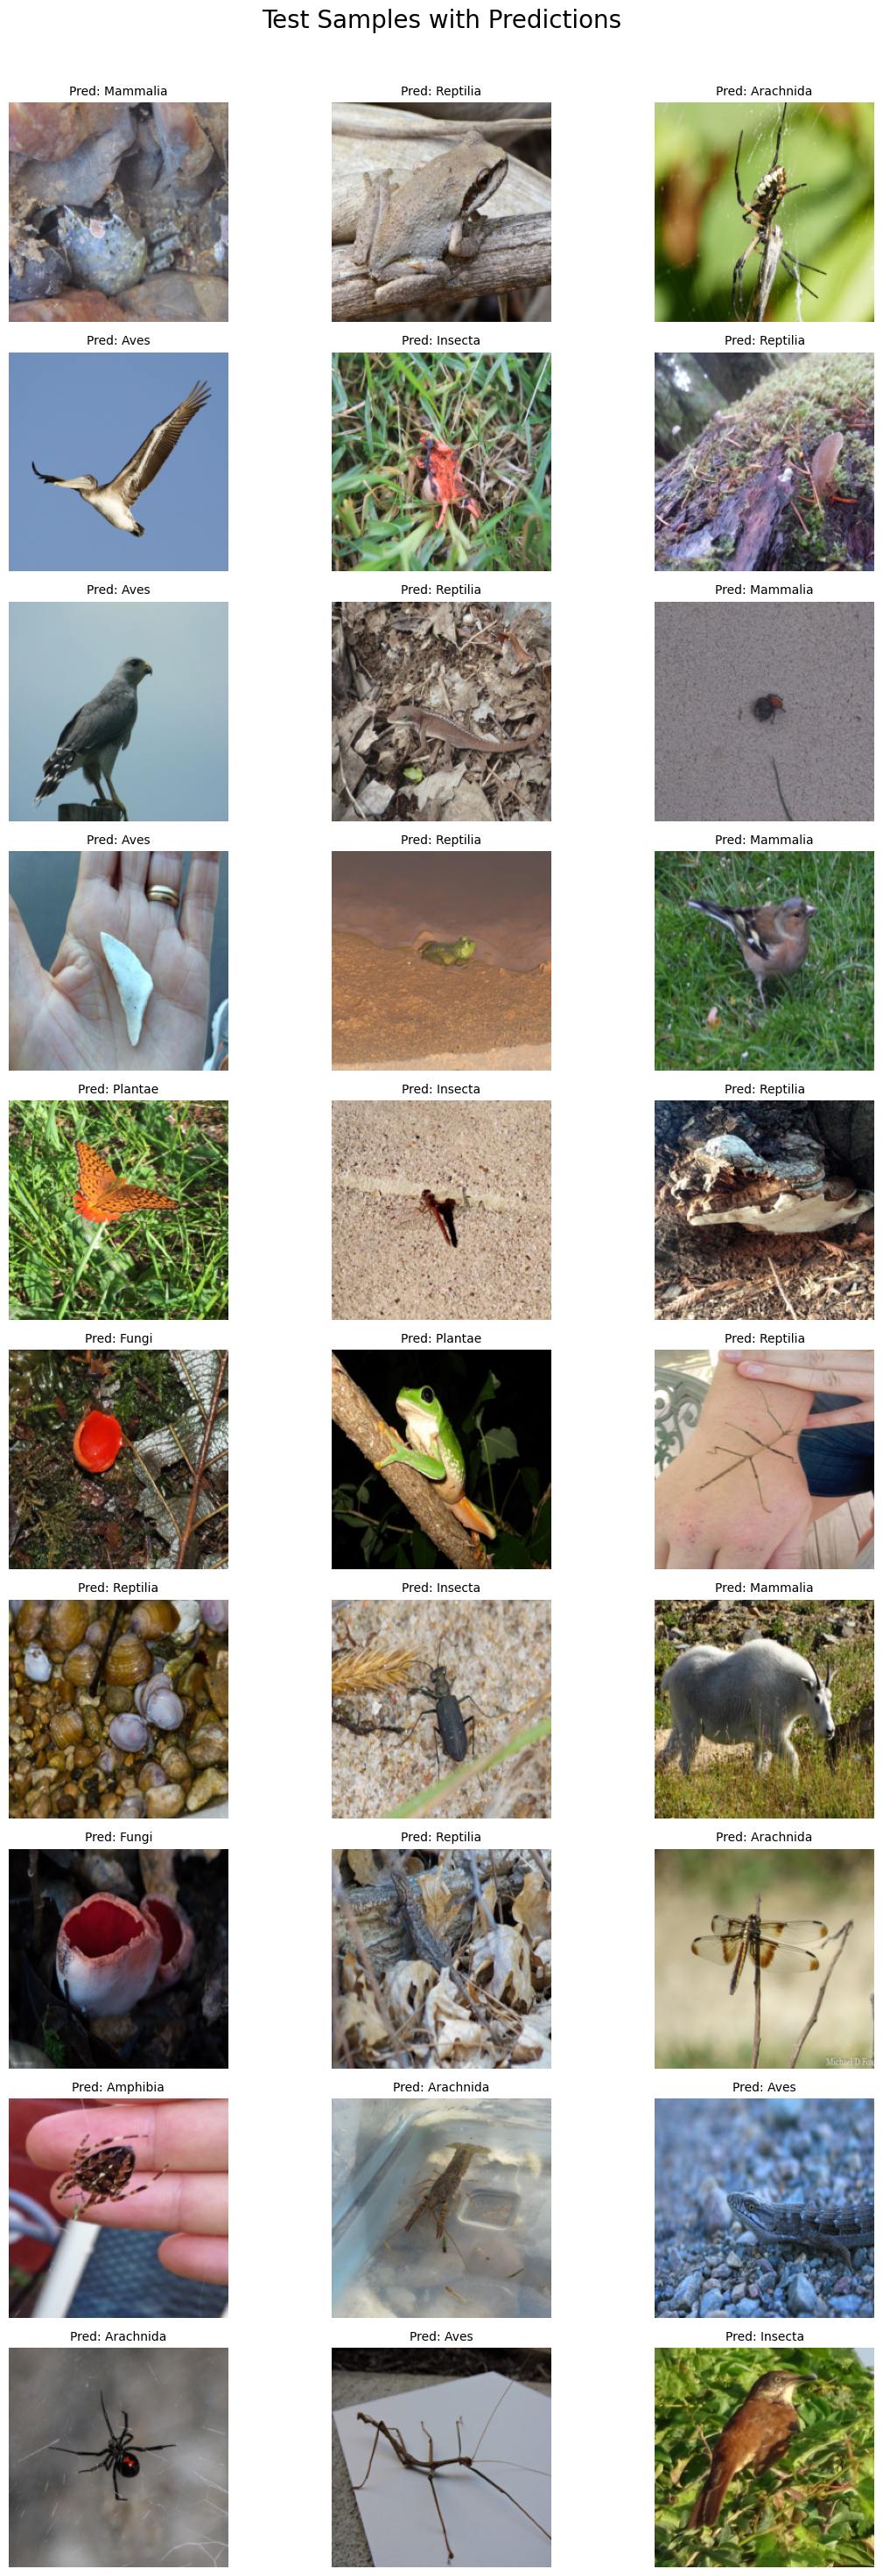

In [10]:
import os
import json
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# from model import CustomCNN  # assuming your model is saved in model.py
from PIL import Image

# Paths
data_dir = "/kaggle/input/nature/nature_12K/inaturalist_12K"
model_dir = "/kaggle/working/"  # contains best_model.pth and best_config.json

# Load config
with open(os.path.join(model_dir, "best_config.json"), "r") as f:
    config = json.load(f)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform for test
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load test data
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Rebuild model
model = CustomCNN(
    conv_configs=[(f, 3) for f in config["filters"]],
    activation_fn=getattr(nn, config["activation"]),
    dense_neurons=config["dense_units"],
    dropout_rate=config["dropout"],
    num_classes=10,
    input_size=224
).to(device)

# Load weights
model.load_state_dict(torch.load(os.path.join(model_dir, "best_model.pth"), map_location=device))
model.eval()

# Evaluate accuracy
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"✅ Test Accuracy: {test_accuracy:.4f}")

# Show 10x3 grid of predictions
import random

class_names = test_dataset.classes
sample_indices = random.sample(range(len(test_dataset)), 30)
fig, axes = plt.subplots(10, 3, figsize=(12, 30))
fig.suptitle("Test Samples with Predictions", fontsize=20)

for ax, idx in zip(axes.flatten(), sample_indices):
    image, true_label = test_dataset[idx]
    input_tensor = image.unsqueeze(0).to(device)
    pred = model(input_tensor).argmax(1).item()

    ax.imshow(image.permute(1, 2, 0))
    ax.axis("off")
    ax.set_title(f"Pred: {class_names[pred]}", fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
